In [1]:
import os
from random import sample
import datetime
import numpy as np

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
from pytorch_unet import UNet
from dataset_loader import DataAugmentor
%load_ext tensorboard

/home/nick/anaconda3/lib/python3.7/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


In [2]:
this_notebook_name = "PyTorchSagittalSpineSegmentationStudy"

# Update this folder name for your computer

local_data_folder = r"/home/nick/dev/SaggitalSpineSegmentation_Data"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

# Learning parameters
ultrasound_size = 128
num_classes = 2
num_epochs = 300 # was 500
batch_size = 128
max_learning_rate = 0.02
min_learning_rate = 0.0001

# I will use exponential learning rate decay, not linear
# need to solve the system of equations:

# x**y = max_learning_rate
# x**(num_epochs + y) = min_learning_rate

# Here, x is the decay factor we want
# solving analytically by hand bc I am a math major (and sympy failed):

# y*ln(x) = ln(max_learning_rate)
# (num_epochs + y) * ln(x) = ln(min_learning_rate)
# (num_epochs + (ln(max_learning_rate)/ln(x)))*ln(x) = ln(min_learning_rate)
# ln(x)*num_epochs + ln(max_learning_rate) = ln(min_learning_rate)
# ln(x) = (ln(min_learning_rate) - ln(max_learning_rate))/num_epochs
# ln(x) = ln( (min_learning_rate / max_learning_rate)**(1/num_epochs) )
# x = (min_learning_rate / max_learning_rate)**(1/num_epochs)

learning_rate_decay = (min_learning_rate / max_learning_rate)**(1/num_epochs)

regularization_rate = 0.001
filter_multiplier = 10
WCE_weights = np.array([0.1, 0.9])

# Training data augmentation parameters

max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

limit_validation_rounds = -1

# Uncomment for faster debugging

# roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01]
# limit_validation_rounds = 1
# num_epochs = 1

Save timestamp: 2021-08-05_08-31-07


In [3]:
# Define what data to download

girder_api_url = "https://pocus.cs.queensu.ca/api/v1"

training_ultrasound_ids = [
    "5da9e5c0d9e6a3be02d012b4",
    "5da9e5c7d9e6a3be02d012c6",
    "5da9e5c2d9e6a3be02d012b7",
    "5da9e5c3d9e6a3be02d012ba",
    "5da9e5c8d9e6a3be02d012c9",
    "5da9e5c5d9e6a3be02d012c0",
    "5da9e5c6d9e6a3be02d012c3",
    "5da9e5c4d9e6a3be02d012bd"
]

training_ultrasound_filenames = [
    "q000_ultrasound.npy",
    "q001_ultrasound.npy",
    "q002_ultrasound.npy",
    "q003_ultrasound.npy",
    "q004_ultrasound.npy",
    "q005_ultrasound.npy",
    "q006_ultrasound.npy",
    "q007_ultrasound.npy"
]

training_segmentation_ids = [
    "5da9e5c8d9e6a3be02d012cc",
    "5da9e5ccd9e6a3be02d012de",
    "5da9e5c9d9e6a3be02d012cf",
    "5da9e5cad9e6a3be02d012d2",
    "5da9e5cdd9e6a3be02d012e1",
    "5da9e5cbd9e6a3be02d012d8",
    "5da9e5cbd9e6a3be02d012db",
    "5da9e5cad9e6a3be02d012d5"
]

training_segmentation_filenames = [
    "q000_segmentation.npy",
    "q001_segmentation.npy",
    "q002_segmentation.npy",
    "q003_segmentation.npy",
    "q004_segmentation.npy",
    "q005_segmentation.npy",
    "q006_segmentation.npy",
    "q007_segmentation.npy"
]

In [4]:
# These subfolders will be created/populated in the data folder

data_arrays_folder    = "DataArrays"
notebooks_save_folder = "SavedNotebooks"
results_save_folder   = "SavedResults"
models_save_folder    = "SavedModels"
val_data_folder       = "PredictionsValidation"

data_arrays_fullpath = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath = os.path.join(local_data_folder, notebooks_save_folder)
results_save_fullpath = os.path.join(local_data_folder, results_save_folder)
models_save_fullpath = os.path.join(local_data_folder, models_save_folder)
val_data_fullpath = os.path.join(local_data_folder, val_data_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(results_save_fullpath):
    os.makedirs(results_save_fullpath)
    print("Created folder: {}".format(results_save_fullpath))

if not os.path.exists(models_save_fullpath):
    os.makedirs(models_save_fullpath)
    print("Created folder: {}".format(models_save_fullpath))

if not os.path.exists(val_data_fullpath):
    os.makedirs(val_data_fullpath)
    print("Created folder: {}".format(val_data_fullpath))

In [5]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading training files ...")

# Setting up number of validation rounds

n_files = len(training_ultrasound_ids)
if limit_validation_rounds > 0:
    num_validation_rounds = min(n_files, limit_validation_rounds)
else:
    num_validation_rounds = n_files

# Preparing progress bar

f = IntProgress(min=0, max=n_files*2)
display(f)

# Downloading files

gclient = girder_client.GirderClient(apiUrl=girder_api_url)

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    if not os.path.exists(ultrasound_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(ultrasound_fullname))
        gclient.downloadFile(training_ultrasound_ids[i], ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])
    if not os.path.exists(segmentation_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(segmentation_fullname))
        gclient.downloadFile(training_segmentation_ids[i], segmentation_fullname)
    f.value = i * 2 + 2

time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))

IntProgress(value=0, max=16)


Total download time: 0:00:00.014615


In [6]:
# Read data into torch tensors in channel-first format, dtype float

ultrasound_tensors = []
segmentation_tensors = []

f = IntProgress(min=0, max=n_files * 2)
display(f)

time_start = datetime.datetime.now()

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])

    ultrasound_data = np.load(ultrasound_fullname)
    ultrasound_data = torch.Tensor(ultrasound_data).permute(0,3,1,2).float()
    f.value = i * 2 + 1
    
    segmentation_data = np.load(segmentation_fullname)
    segmentation_data = torch.Tensor(segmentation_data).long().permute(0,3,1,2)

    f.value = i * 2 + 2
    
    ultrasound_tensors.append(ultrasound_data)
    segmentation_tensors.append(segmentation_data)

time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))

IntProgress(value=0, max=16)


Total time to load from files: 0:00:00.166797


In [7]:
# Use cuda GPU if available

device_name = " "
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
else:
    device_name = 'CPU'
    
print('Using device:', device_name)

device = "cuda" if torch.cuda.is_available() else "cpu"

Using device: GeForce RTX 2060 SUPER


In [8]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 7210), started 9:03:36 ago. (Use '!kill 7210' to kill it.)

Timestamp for saved files: 2021-08-05_08-31-07

Training parameters
Number of epochs:    300
Step size maximum:   0.02
Step size decay:     0.9824939845150137
Batch size:          128
Regularization rate: 0.001

Saving validation predictions in: /home/nick/dev/SaggitalSpineSegmentation_Data/PredictionsValidation
Saving models in:                 /home/nick/dev/SaggitalSpineSegmentation_Data/SavedModels

*** Leave-one-out round # 0

Training on 2767 images, validating on 523 images...


IntProgress(value=0, max=300)

AssertionError: 

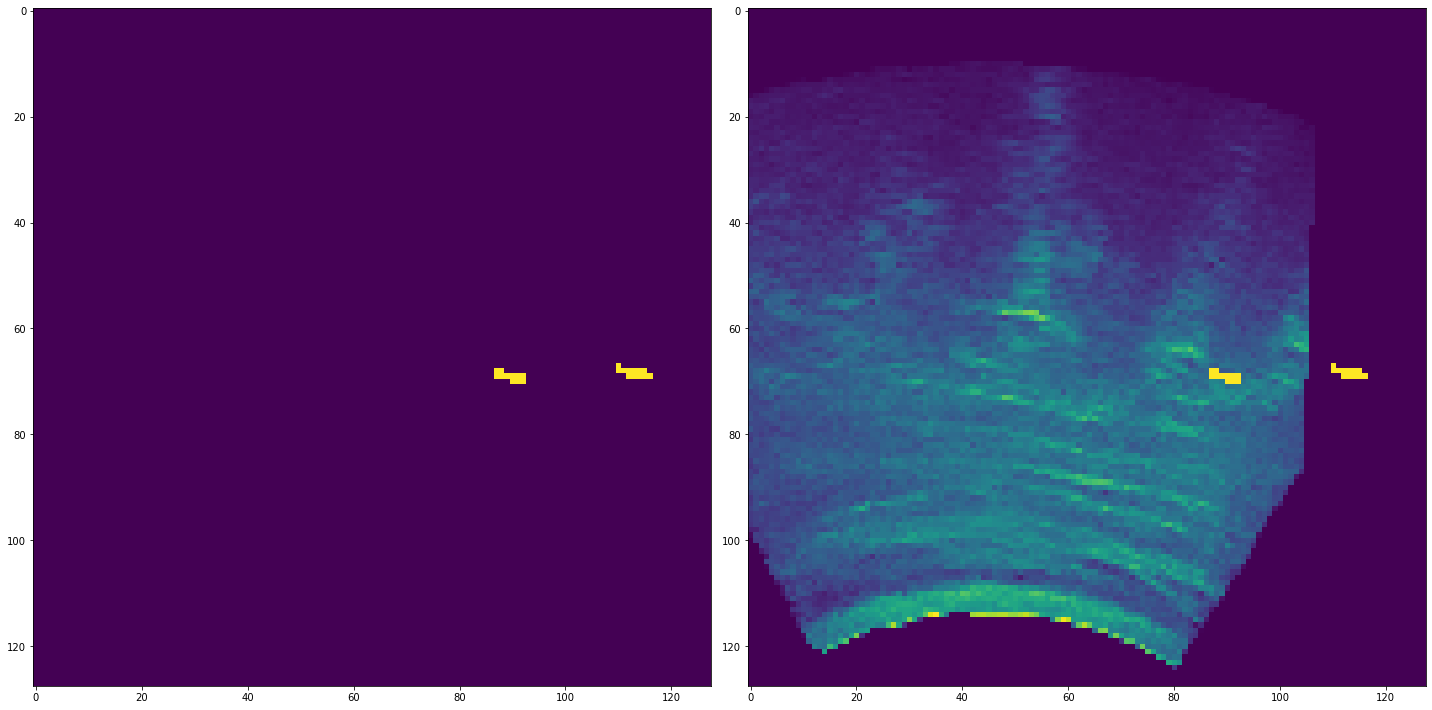

In [9]:
# This is where all the training gets done

# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()

print("Timestamp for saved files: {}".format(save_timestamp))
print("\nTraining parameters")
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))
print("")
print("Saving validation predictions in: {}".format(val_data_fullpath))
print("Saving models in:                 {}".format(models_save_fullpath))

# ROC data will be saved in these containers

val_best_metrics    = dict()
val_fuzzy_metrics   = dict()
val_aurocs          = np.zeros(num_validation_rounds)
val_best_thresholds = np.zeros(num_validation_rounds)

# Initialize metrics

train_loss = 0.0
val_loss = 0.0
val_dice = 0.0

# Perform validation rounds

for i in range(num_validation_rounds):
    
    f = IntProgress(min=0, max=num_epochs)
     
    # Set Up TensorBoard
    
    writer = SummaryWriter()
    
#   Prepare data arrays
#   leave out ultrasound_arrays[i]
    
    train_ultrasound_data = torch.zeros(
        [0, ultrasound_tensors[0].shape[1], ultrasound_tensors[0].shape[2], ultrasound_tensors[0].shape[3]]).float()
    train_segmentation_data = torch.zeros(
        [0, ultrasound_tensors[0].shape[1], ultrasound_tensors[0].shape[2], ultrasound_tensors[0].shape[3]]).long()
    
    val_ultrasound_data = ultrasound_tensors[i]
    val_segmentation_data = segmentation_tensors[i]
    val_ultrasound_filename = training_ultrasound_filenames[i]
    
    for train_index in range(n_files):
        if train_index != i:
            train_ultrasound_data = torch.cat((train_ultrasound_data, ultrasound_tensors[train_index]))
            train_segmentation_data = torch.cat((train_segmentation_data, segmentation_tensors[train_index]))
    
    n_train = train_ultrasound_data.size(0)
    n_val = val_ultrasound_data.size(0)
    
    print("\n*** Leave-one-out round # {}".format(i))
    print("\nTraining on {} images, validating on {} images...".format(n_train, n_val))
    
    display(f)
    
    # Create and train model

    model = UNet(128,num_classes).to(device).train()
    optim = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optim, gamma=learning_rate_decay)
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(WCE_weights).float()).to(device)
    dice_metric = torchmetrics.F1(num_classes=num_classes, mdmc_average='global').to(device).eval()
    softmax = torch.nn.Softmax(dim=1).to(device)
    
    # PyTorch Datasets and DataLoaders
    
    training_dataset = DataAugmentor(train_ultrasound_data,
                                     train_segmentation_data,
                                     image_dimensions=(ultrasound_size, ultrasound_size),
                                     max_rotation_angle=max_rotation_angle,
                                     max_shift_factor=max_shift_factor,
                                     min_zoom_factor=min_zoom_factor,
                                     max_zoom_factor=max_zoom_factor)
    training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, num_workers=4)
    
    val_dataset = DataAugmentor(val_ultrasound_data,
                                val_segmentation_data,
                                image_dimensions=(ultrasound_size, ultrasound_size),
                                max_rotation_angle=max_rotation_angle,
                                max_shift_factor=max_shift_factor,
                                min_zoom_factor=min_zoom_factor,
                                max_zoom_factor=max_zoom_factor)
    val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
        
    training_time_start = datetime.datetime.now()
    
    # training loop for this validation split
    for epoch in range(1, num_epochs+1):
        train_loss = 0.0
        val_loss = 0.0
        val_dice = 0.0
        
        # training
        model.train()
        num = 0
        for batch, target in training_generator:
            num += 1
            optim.zero_grad()
            batch = batch.to(device)
            target = target.to(device)
            pred = model(batch).to(device)
            loss = criterion(pred, target.squeeze(1))
            loss += regularization_rate * sum(x.abs().sum()for k, x in model.named_parameters() if k.endswith('conv.bias')) * 1e-5
            loss.backward()
            train_loss += loss.item() * batch.size(0)
            optim.step()
            
            fig, axs = plt.subplots(1,2)
            fig.set_size_inches(20,15)
            idx = int(np.random.rand()*127)
            gt_np = torch.squeeze(target, dim=1).to('cpu').detach().numpy()[idx]
            axs[0].imshow(gt_np)
            img_np = torch.squeeze(batch, dim=1).to('cpu').detach().numpy()[idx]
            img_np[gt_np == 1] = 1
            axs[1].imshow(img_np)
            plt.tight_layout()
            assert False
        
        lr_scheduler.step()
        train_loss = train_loss / training_dataset.__len__()
        
        # validation
        model.eval()
        num = 0
        for batch, target in val_generator:
            num += 1
            batch = batch.to(device)
            target = target.to(device)
            pred = model(batch).to(device)
            loss = criterion(pred, target.squeeze(1))
            val_loss += loss.item() * batch.size(0)
            pred_probmap = softmax(pred)
#             if(epoch == 100):
#                 print(pred_probmap.size())
#                 img = pred_probmap[10,1,:,:].to('cpu').detach().numpy()
#                 plt.imshow(img)
#                 print(np.max(img))
#                 print(np.min(img))
#                 print(np.count_nonzero(img > 0.5))
#                 assert False
            dice = dice_metric(pred_probmap, target)
            val_dice += dice.item()
        
        if epoch==1:
            writer.add_graph(model, batch)
            
        val_loss = val_loss / val_dataset.__len__()
        val_dice = val_dice / num
        
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalar('Dice/validation', val_dice, epoch)
        writer.add_scalar('Meta/learning_rate', lr_scheduler.get_last_lr()[-1], epoch)
        
        f.value = epoch
        

    training_time_stop = datetime.datetime.now()
    
    # Print training log
    
    print("\nMetrics at the end of training")
    print("  val loss:      {}".format(val_loss))
    print("  val_dice:      {}".format(val_dice))
    print("  Training time: {}".format(training_time_stop-training_time_start))
    
    # TODO Plot training loss and metrics
    
    # Predict on validation data
    
    y_pred_val  = model(val_ultrasound_data.to(device))
    
    # Saving predictions for further evaluation
    
    filename_noext, extension = os.path.splitext(val_ultrasound_filename)
    val_prediction_filename = save_timestamp + "_prediction_" + filename_noext + ".npy"
    val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
    torch.save(y_pred_val, val_prediction_fullname)
    
    # Archive trained model with unique filename based on notebook name and timestamp
    
    model_file_name = this_notebook_name + "_model-" + str(i) + "_" + save_timestamp + ".msd"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    torch.save(model.state_dict(), model_fullname)
    
    # Validation results
     
#     vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
#         roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
#     val_fuzzy_metrics[i] = evaluation_metrics.compute_evaluation_metrics(
#         y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
#     val_best_metrics[i]    = vali_metrics_dicts[vali_best_threshold_index]
#     val_aurocs[i]          = vali_area
#     val_best_thresholds[i] = roc_thresholds[vali_best_threshold_index]
    
    # Printing total time of this validation round
    
    print("\nTotal round time:  {}".format(datetime.datetime.now() - training_time_start))
    print("")
    
    # just do one validation split
    break


time_sequence_stop = datetime.datetime.now()

print("\nTotal training time:   {}".format(time_sequence_stop - time_sequence_start))


In [ ]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

In [ ]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

In [ ]:
assert False

In [ ]:
val_ultrasound_data.size()

In [ ]:
y_pred_val.size()

In [ ]:
val_segmentation_data.size()

In [ ]:
pred_sm = torch.nn.functional.softmax(y_pred_val, dim=1)
pred_sm = pred_sm[:,1,:,:]
pred_sm.size()
# torch.nn.functional.softmax(y_pred_val, dim=1)[:,1,:,:].to('cpu').detach().numpy()

In [ ]:
pred_sm_np = np.array(pred_sm.to('cpu').detach().numpy())
np.shape(pred_sm_np)


In [ ]:
gt_np = torch.squeeze(val_segmentation_data, dim=1).detach().numpy()
np.shape(gt_np)

In [ ]:
index = int(523*np.random.rand())

fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,15)
axs[0].imshow(gt_np[index])
axs[1].imshow(pred_sm_np[index])
plt.tight_layout()

In [ ]:
#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah#blah#blah
#blah#blah
#blah#blah